# BERT Document Classification Tutorial
> BERT Document Classification Tutorial  with Code
> ref: https://colab.research.google.com/drive/1CfsGHuNWGGLg7ArPD_WE3sRuzFbDJav8#scrollTo=NxlZsafTC-V5

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [bert, jupyter]
- hide: true
- search_exclude: true

# Classifying Wikipedia Comments with BERT

# Contents

# Part I - Setup & Dataset Prep

## 1. Setup

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print("Found GPU at : {}".format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at : /device:GPU:0


In [2]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [3]:
import torch

# If there's a GPU available,
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# IF not,
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [4]:
! pip install transformers -q

     |████████████████████████████████| 573kB 42.4MB/s 
     |████████████████████████████████| 1.0MB 49.5MB/s 
     |████████████████████████████████| 3.7MB 50.7MB/s 
     |████████████████████████████████| 890kB 36.4MB/s 


## 2. Retrieve & Inspect Dataset

In [5]:
import urllib
import os

# Create the data subdirectory if not there.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

files = [
         ('./data/attack_annotated_comments.tsv', 'https://ndownloader.figshare.com/files/7554634'),
         ('./data/attack_annotations.tsv', 'https://ndownloader.figshare.com/files/7554637')
]

for (filename, url) in files:
    # Download download if we don't already have it!
    if not os.path.exists(filename):

        # Download the dataset.
        print('Downloading', filename)

        urllib.request.urlretrieve(url, filename)

        print('   DONE.')

   DONE.
   DONE.


In [70]:
import pandas as pd

print('Parsing the dataset .tsv file...')
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep='\t', index_col = 0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep='\t')

print('   Done.')

Parsing the dataset .tsv file...
   Done.


In [71]:
# Display the first five rows of the table.
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [72]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [73]:
annotations.sample(5)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
107339,44745233,2584,0.0,0.0,0.0,0.0,0.0
1225742,602195543,330,0.0,0.0,0.0,0.0,0.0
1134782,534921976,478,0.0,0.0,0.0,0.0,0.0
964600,421581160,57,0.0,0.0,0.0,0.0,0.0
199505,70323643,1893,0.0,1.0,0.0,0.0,1.0


In [0]:
# Label a comment as an attack if the majority of annotators did so
# The comments are uniquely identified by their 'rev_id'.  The annotations table
# has multiple rows for each comment because there were multiple labelers.
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

# Join labels and comments
comments['attack'] = labels

In [0]:
# Remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [0]:
# fit a simple text classifier
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

In [13]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

# Filter to just the "attack" comments.
attack_examples = train_comments.query('attack')['comment']

# Randomly choose some examples.
for i in range(10):
    j = random.choice(attack_examples.index)

    print('')
    print(wrapper.fill(attack_examples[j]))
    print('')


I SHOULD BE UNBANNED THIS INSTANT! GO TO HELL Android79!


  == Booshakla ==  The guy was a sockpuppeteer here on Wikipedia. Quit acting
like a cunt.


  ====  FUCK YOU YOU PIECE OF SHIT! WHY THE FUCK HAVE YOU DELETED MY ARTICLES? I
WILL REPORT YOU YOU FUCKING PIECE OF SHIT!


  == douchebag ==  you're an asshole.  charlie.


  == guess what ==  your retarded


  ::you're right. allmusic is the last shit.


` ::::::: It's not an encyclopedia.  Brittanica is an encyclopedia. Brittanica
doesn't choose to employ [User:Essjay|lying pissants] as a reward for their
duplicitous behavior.  This online ``encyclopedia``, you self-righteous inbred
piece of shit, is a caricature.`


   ::::::::::::::::::::::;WHAT THE FUCK IS WRONG WITH YOU PEOPLE? STOP CRITIZING
US!!! YOU'RE WRITING IN OPINION!! FUCK STOP THIS! MADDOX IS A PRICK


  The Greater San Francisco Bay Area is greater than the typical Bay Area
Definition you idiot stop reverting my edits until YOU have sources obviously
like every other

In [14]:
total_comments = len(comments)
num_attacks = len(comments.query('attack'))

print('{:,} of {:,} comments are attacks ({:.2%})'.format(num_attacks, total_comments, num_attacks/total_comments))

13,590 of 115,864 comments are attacks (11.73%)


In [15]:
prcnt_non_attack = 1 - (len(test_comments.query('attack')) / len(test_comments))

print('Always predicting "not attack" will yeild {:.2%} accuracy on the test set.'.format(prcnt_non_attack))

Always predicting "not attack" will yeild 88.11% accuracy on the test set.


## 3. BERT Input Length Limitation

In [16]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [17]:
# Retrieve the text of the first comment.
text = train_comments.iloc[0].comment

# Run the tokenizer to count up the number of tokens. The tokenizer will split
# the text into words, punctuation, and subwords as needed.
tokens = tokenizer.tokenize(text)

print('Comment 0 (not an attack) contains {:,} WordPiece tokens.'.format(len(tokens)))
print('\nOriginal comment text:\n')
print(wrapper.fill(text))

Comment 0 (not an attack) contains 591 WordPiece tokens.

Original comment text:

`- This is not ``creative``.  Those are the dictionary definitions of the terms
``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you
don't understand that, fine, legitimate criticism, I'll write up ``three man
cell`` and ``bounty hunter`` and then it will be easy to understand why
``ensured`` and ``insured`` are different - and why both differ from
``assured``.  The sentence you quote is absolutely neutral.  You just aren't
familiar with the underlying theory of strike-back (e.g. submarines as employed
in nuclear warfare) guiding the insurance, nor likely the three man cell
structure that kept the IRA from being broken by the British.  If that's my
fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or
``creative`` about it.  I'm tired of arguing with you.  Re: the other article,
``multi-party`` turns up plenty, and there is more use of ``mutually`` than
``

In [18]:
# Print out the list of tokens
print('==== First 512 tokens: ====\n')
print(wrapper.fill(str(' '.join(tokens[0:512]))))

print('')

print('\n==== Remaining {:,} tokens: ====\n'.format(len(tokens) - 512))
print(wrapper.fill(str(' '.join(tokens[512:]))))

==== First 512 tokens: ====

` - this is not ` ` creative ` ` . those are the dictionary definitions of the
terms ` ` insurance ` ` and ` ` en ##sur ##ance ` ` as properly applied to ` `
destruction ` ` . if you don ' t understand that , fine , legitimate criticism ,
i ' ll write up ` ` three man cell ` ` and ` ` bounty hunter ` ` and then it
will be easy to understand why ` ` ensured ` ` and ` ` ins ##ured ` ` are
different - and why both differ from ` ` assured ` ` . the sentence you quote is
absolutely neutral . you just aren ' t familiar with the underlying theory of
strike - back ( e . g . submarines as employed in nuclear warfare ) guiding the
insurance , nor likely the three man cell structure that kept the ira from being
broken by the british . if that ' s my fault , fine , i can fix that to explain
. but the ##r ' es nothing ` ` personal ` ` or ` ` creative ` ` about it . i ' m
tired of arguing with you . re : the other article , ` ` multi - party ` ` turns
up plenty , and the

In [19]:
# First truncate the text to remove the last 79 tokens (which begin with the words "are made in").
last_char = text.find('are made in')

# Trancate the text to only what fits in the 512 tokens.
text = text[:last_char]

# Estimate the number of words in the comment by splitting it on whitespace.
# First remove all double spaces.
text = text.replace('  ', ' ')
num_words = len(text.split(' '))

print('Comment contains ~{:,} words.'.format(num_words))

# Estimate the number of sentences by counting up the periods.
num_sens = text.count('. ')

print('Comment contains ~{:,} sentences.'.format(num_sens))

Comment contains ~330 words.
Comment contains ~20 sentences.


In [20]:
import numpy as np

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence,
for sen in train_comments.comment:

    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))

    # `encode` will:
    #    (1) Tokenize the sentence.
    #    (2) Prepend the `[CLS]` token to the start.
    #    (3) Append the `[SEP]` token to the end.
    #    (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sen,                                        # Sentence to encode.
        add_special_tokens = True,      # Add [CLS]' and '[SEP]'
        #max_length = 512,                  # Truncate all sentences.
        #return_tensors = 'pt',             # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} comments'.format(len(input_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
  Read 0 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

  Read 20,000 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (959 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1074 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

  Read 40,000 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2054 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2041 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

  Read 60,000 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1002 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1398 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

DONE.
    69,526 comments


In [21]:
# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and conver from booleans to ints.
labels = train_comments.attack.to_numpy().astype(int)

print('{:>7,} positive (contains attack)'.format(np.sum(labels)))
print('{:>7,} negative (not an attack)'.format(len(labels) - np.sum(labels)))


  8,079 positive (contains attack)
 61,447 negative (not an attack)


In [22]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 2 tokens
   Max length: 9,861 tokens
Median length: 52.0 tokens


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, '# of Comments')

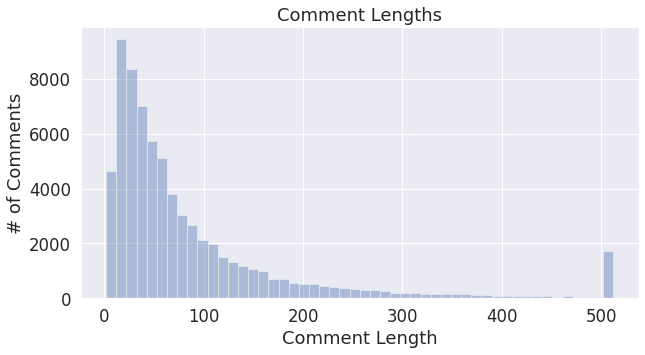

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is tricky.
# See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
# plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')


In [24]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(512)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

1,668 of 69,526 sentences (2.4%) in the training set are longer than 512 tokens.


In [25]:
# Tally up how many of the truncated sentences are positive vs. negative examples.
num_pos = 0
num_neg = 0

# Iterate through the comment lengths,
for i, l in enumerate(lengths):

    # If the sentence was truncated,
    if l == 512:

        # Tally up whether it contains a personal attack or not.
        if labels[l] == 1:
            num_pos += 1
        else:
            num_neg += 1
    
# Report the total.
print('{:,} ({:.1%}) of the truncated examples contain a personal attack'.format(num_pos, num_pos / (num_neg + num_pos)))

0 (0.0%) of the truncated examples contain a personal attack


In [26]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the required sequnce length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0


Using TensorFlow backend.



Done.


In [27]:
input_ids[0]

array([  101,  1036,  1011,  2023,  2003,  2025,  1036,  1036,  5541,
        1036,  1036,  1012,  2216,  2024,  1996,  9206, 15182,  1997,
        1996,  3408,  1036,  1036,  5427,  1036,  1036,  1998,  1036,
        1036,  4372, 26210,  6651,  1036,  1036,  2004,  7919,  4162,
        2000,  1036,  1036,  6215,  1036,  1036,  1012,  2065,  2017,
        2123,  1005,  1056,  3305,  2008,  1010,  2986,  1010, 11476,
        6256,  1010,  1045,  1005,  2222,  4339,  2039,  1036,  1036,
        2093,  2158,  3526,  1036,  1036,  1998,  1036,  1036, 17284,
        4477,  1036,  1036,  1998,  2059,  2009,  2097,  2022,  3733,
        2000,  3305,  2339,  1036,  1036, 16316,  1036,  1036,  1998,
        1036,  1036, 16021, 12165,  1036,  1036,  2024,  2367,  1011,
        1998,  2339,  2119, 11234,  2013,  1036,  1036,  8916,  1036,
        1036,  1012,  1996,  6251,  2017, 14686,  2003,  7078,  8699,
        1012,  2017,  2074,  4995,  1005,  1056,  5220,  2007,  1996,
       10318,  3399]

In [28]:
input_ids[2]

array([  101,  2995,  2030,  6270,  1010,  1996,  3663,  2004,  1997,
        2233,  2526,  2001,  2107,  1024,  1037,  8174,  6378,  1997,
        2455,  2005,  3521,  1998,  5038,  2011,  2035,  5424,  3032,
        2001,  2081,  1012,  1996,  2154,  1996,  6378,  2001,  2000,
        2022,  2081,  5337,  2011,  1996,  5424,  2223,  2001,  1996,
        2154,  1996,  5611,  1005,  1055,  2104,  1996,  3094,  1997,
       16126, 10666,  2211,  1996,  5274,  1997,  1996,  9302,  2969,
        1011,  3627,  2752,  1012,  5310,  1024,  5424,  1012,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [0]:
# Create attention masks
attention_masks = []

# For each sentence,
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size = 0.1)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Part II - BERT Fine-Tuning

## Train Our Classification Model

In [33]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                                # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix'
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,    # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8    # args.adam_epsilon - default is 1e-8.
                  )

In [35]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

7824


In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [38]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch,
for epoch_i in range(0, epochs):

    # =======================================
    #                               Training
    # =======================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i+1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0  = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*,
    # it doesn't *perform* the training. `dropout` and `batchnorm` layers behave differently during 
    # training vs. test 
    model.train()

    # For each batch of training data,
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,} of {:5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        # PyTorch doesn't do this automatically because accumulating the gradients is 
        # "convenient while trainig RNNs".
        model.zero_grad()

        # Perform a forwad pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified
        # based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # =======================================
    #                               Validation
    # ======================================= 
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy= 0,  0
    nb_eval_steps, nb_eval_examples = 0, 0  

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add  batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up validataion
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence task.
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            
        # Get the "logits" output by the model. The "logits" are the output values prior to applying 
        # an activation function like the softmax.
        logits = output[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch   100 of 1,956.    Elapsed: 0:01:14.
  Batch   200 of 1,956.    Elapsed: 0:02:28.
  Batch   300 of 1,956.    Elapsed: 0:03:43.
  Batch   400 of 1,956.    Elapsed: 0:04:57.
  Batch   500 of 1,956.    Elapsed: 0:06:12.
  Batch   600 of 1,956.    Elapsed: 0:07:26.
  Batch   700 of 1,956.    Elapsed: 0:08:40.
  Batch   800 of 1,956.    Elapsed: 0:09:55.
  Batch   900 of 1,956.    Elapsed: 0:11:09.
  Batch 1,000 of 1,956.    Elapsed: 0:12:24.
  Batch 1,100 of 1,956.    Elapsed: 0:13:38.
  Batch 1,200 of 1,956.    Elapsed: 0:14:53.
  Batch 1,300 of 1,956.    Elapsed: 0:16:07.
  Batch 1,400 of 1,956.    Elapsed: 0:17:22.
  Batch 1,500 of 1,956.    Elapsed: 0:18:36.
  Batch 1,600 of 1,956.    Elapsed: 0:19:51.
  Batch 1,700 of 1,956.    Elapsed: 0:21:06.
  Batch 1,800 of 1,956.    Elapsed: 0:22:20.
  Batch 1,900 of 1,956.    Elapsed: 0:23:35.

  Average training loss: 0.14
  Training epoch took: 0:24:16

Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:52

======== Epoch 

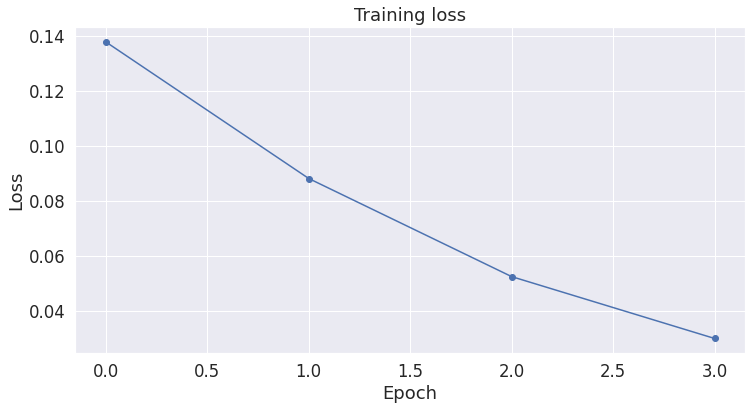

In [39]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Performance On Test Set

In [40]:
# Tokenize all of the sentences and map the tokens to their word IDs.
test_input_ids = []

# For every sentence,
for sen in test_comments.comment:

    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print('  Read {:,} comments.'.format(len(input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sen,                                        # Sentence to encode.
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Truncate all sentences.
    )

    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
print('{:>10,} negative (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", 
                               truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

DONE.

    23,178 test comments
     2,756 positive (contains attack)
    20,422 negative (not an attack)


In [41]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict
for (step, batch) in enumerate(test_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elaped time in minutes.
        elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,} of {:5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)
        
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 23,178 test sentences...
  Batch   100 of   725.    Elapsed: 0:00:24.
  Batch   200 of   725.    Elapsed: 0:00:48.
  Batch   300 of   725.    Elapsed: 0:01:12.
  Batch   400 of   725.    Elapsed: 0:01:36.
  Batch   500 of   725.    Elapsed: 0:02:00.
  Batch   600 of   725.    Elapsed: 0:02:25.
  Batch   700 of   725.    Elapsed: 0:02:49.
    DONE.


In [42]:
predictions[0:10]

[array([[ 5.43135  , -4.0807185],
        [ 4.597425 , -3.4614418],
        [ 5.2029805, -3.8499084],
        [ 5.43569  , -4.196341 ],
        [ 5.240312 , -3.9164932],
        [ 5.4701114, -4.1476755],
        [ 5.4822345, -4.063522 ],
        [ 4.17534  , -3.1728623],
        [ 5.5162745, -4.17683  ],
        [ 5.4228077, -3.9708762],
        [ 5.3999577, -4.0484023],
        [ 5.4844804, -4.143347 ],
        [ 5.554893 , -4.2400174],
        [ 5.3096027, -3.868986 ],
        [ 5.4283338, -4.090388 ],
        [ 5.326691 , -3.9882448],
        [ 3.5734868, -2.635085 ],
        [ 4.595947 , -3.5288842],
        [ 5.4501967, -4.1388345],
        [ 5.5220246, -4.186985 ],
        [ 5.0823264, -3.7486613],
        [ 5.5255437, -4.2840915],
        [ 5.192801 , -3.9431345],
        [ 5.3387275, -4.0219254],
        [ 5.560451 , -4.240357 ],
        [ 5.3670015, -3.9867408],
        [ 5.392772 , -4.103932 ],
        [ 4.2843475, -3.2214487],
        [ 5.487993 , -4.157152 ],
        [ 4.83

In [0]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [44]:
predictions[0:10]

array([[ 5.43135  , -4.0807185],
       [ 4.597425 , -3.4614418],
       [ 5.2029805, -3.8499084],
       [ 5.43569  , -4.196341 ],
       [ 5.240312 , -3.9164932],
       [ 5.4701114, -4.1476755],
       [ 5.4822345, -4.063522 ],
       [ 4.17534  , -3.1728623],
       [ 5.5162745, -4.17683  ],
       [ 5.4228077, -3.9708762]], dtype=float32)

In [45]:
true_labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.973


## Save Trained Model

In [48]:
import os

# Saving best-practices: if you use defaults name for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [49]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
gdrive_path = './drive/My Drive/BERT Document Classification Tutorial/model_save/'

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

# Part III - Semantic Similarity

## Vectorize Comments

In [0]:
model.output_hidden_states = True

In [58]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Copy the model files back from Google Drive to the Colab instance. 
!cp -r "./drive/My Drive/BERT Document Classification Tutorial/model_save/" ./model_save/

In [60]:
from transformers import BertForSequenceClassification, BertTokenizer

# The name of the folder containing the model files.
output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True, # Whether the model returns all hidden-states.
) 

# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
import torch
from keras.preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector representation of the input string, `in_text`.
    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #         STEP 1: Tokenization
    # ===========================

    MAX_LEN = 128

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (3) Prepend the `[CLS]` token to the start.
    #   (4) Append the `[SEP]` token to the end. (After truncating!)
    #   (5) Map tokens to their IDs.
    input_ids = tokenizer.encode(
        in_text,                                    # Sentence to encode.
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Truncate all sentences.
    )

    # Pad our input tokens. Truncation was handled above by the `encode` function,
    # which also makes sure that the `[SEP]` token is placed at the end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one piece of text, 
    # so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long",
                                truncating="post", padding="post")

    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks
    attn_mask = [int(i>0) for i in input_ids]

    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #         STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)

    # Telling the model not to build the backwards graph will make this a little quicker.
    with torch.no_grad():

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        logits, encoded_layers = model(
            input_ids = input_ids,
            token_type_ids = None,
            attention_mask = attn_mask
        )

    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]

    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return vec

In [77]:
# Get the text from one of the comments.
input_text = comments.iloc[10].comment

# Use `textwrap` to print the sentence nicely.
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="    ", width = 80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. Embedding shape:', str(vec.shape))

Getting embedding for sentence:

       :Correct. Full biographical details will put down his birth details, etc.
    It is just a marker to me at the moment to detail the WR aspect. He
    certainly wasn't Belarus; as a geo-political entity it had no real existence
    at the time. I have put a tbc marker on this article for now.

Done. Embedding shape: (768,)


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [79]:
import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(comments)

print('Generating sentence embeddings for all {:,} comments...'.format(num_comments))

row_num = 0

# For each row of the dataframe,
for index, row in comments.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time()-t0)

        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Comment {:>7,} of {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.comment)

    # Store the embeddings.
    embeddings.append(vec)

    row_num += 1

Generating sentence embeddings for all 115,864 comments...
  Comment   2,000 of 115,864.    Elapsed: 0:00:31. Remaining: 0:29:42
  Comment   4,000 of 115,864.    Elapsed: 0:01:03. Remaining: 0:29:22
  Comment   6,000 of 115,864.    Elapsed: 0:01:34. Remaining: 0:28:47
  Comment   8,000 of 115,864.    Elapsed: 0:02:06. Remaining: 0:28:12
  Comment  10,000 of 115,864.    Elapsed: 0:02:36. Remaining: 0:27:32
  Comment  12,000 of 115,864.    Elapsed: 0:03:07. Remaining: 0:26:58
  Comment  14,000 of 115,864.    Elapsed: 0:03:38. Remaining: 0:26:26
  Comment  16,000 of 115,864.    Elapsed: 0:04:09. Remaining: 0:25:52
  Comment  18,000 of 115,864.    Elapsed: 0:04:40. Remaining: 0:25:22
  Comment  20,000 of 115,864.    Elapsed: 0:05:11. Remaining: 0:24:49
  Comment  22,000 of 115,864.    Elapsed: 0:05:41. Remaining: 0:24:17
  Comment  24,000 of 115,864.    Elapsed: 0:06:12. Remaining: 0:23:45
  Comment  26,000 of 115,864.    Elapsed: 0:06:43. Remaining: 0:23:13
  Comment  28,000 of 115,864.  

In [80]:
import numpy as np

# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

(115864, 768)

In [81]:
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.
print("Saving embeddings to: ./model_save/embeddings.npy")
np.save('./model_save/embeddings.npy', vecs)

# Copy the embeddings to a directory in your Google Drive.
!cp -r ./model_save/embeddings.npy "./drive/My Drive/BERT Document Classification Tutorial/model_save/"

Saving embeddings to: ./model_save/embeddings.npy


## Semantic Similarity Search

In [0]:
!pip install faiss -q

In [0]:
!pip install faiss-gpu -q

In [100]:
import faiss

# =====================================
#            FAISS Setup
# =====================================

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPU.
print('Number of available GPUs: %d    Using: %d' % (faiss.get_num_gpus(), n_gpu))

# If using multiple GPUs, enable sharding so that the dataset is devided across
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()

# gpu_index.add(vecs)
gpu_index.add(vecs)

elapsed = time.time() - t0
print('Building index took %.2f seconds' % (elapsed))

Number of available GPUs: 1    Using: 1


RuntimeError: ignored

In [96]:
import faiss

# =====================================
#            FAISS Setup
# =====================================

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPU.
print('Number of available GPUs: %d    Using: %d' % (faiss.get_num_gpus(), n_gpu))

# If using multiple GPUs, enable sharding so that the dataset is devided across
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
# gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()

# gpu_index.add(vecs)
cpu_index.add(vecs)

elapsed = time.time() - t0
print('Building index took %.2f seconds' % (elapsed))

Number of available GPUs: 1    Using: 1
Adding dataset to index...
Building index took 0.24 seconds


In [97]:
# Coment number 4 is short and sweet.
print('==== Input Comment ====')
print('Comment #4:')
print(wrapper.fill(comments.iloc[4].comment))

# Let's find the 5 most similar comments.
D, I = cpu_index.search(vecs[4].reshape(1, 768), k=5)

print('')
print('==== Top 5 Results ====')

# For each result,
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')

==== Input Comment ====
Comment #4:
    This page will need disambiguation.

==== Top 5 Results ====
Comment #4:
L2 Distance: 0.00
    "This page will need disambiguation. "

Comment #8,612:
L2 Distance: 16.44
    "why can't i edit this page?"

Comment #39,578:
L2 Distance: 16.64
    "  This page needs to be expand.   "

Comment #2,051:
L2 Distance: 16.74
    " The article is somewhat confusing on this point - perhaps someone can
    offer some clarification."

Comment #59,036:
L2 Distance: 17.31
    "  *As these issues remain uneddressed, this article has now been delisted.
    "



In [98]:
query_text = "The meadning of this page needs to be clarified."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = cpu_index.search(query_vec.reshape(1, 768), k=5)

print('')
print('==== Top 5 Results ====')

# For each result,
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' +text + '"'))
    print('')


==== Top 5 Results ====
Comment #39,578:
L2Distance: 17.01
    "  This page needs to be expand.   "

Comment #88,451:
L2Distance: 17.39
    "  I intend to expand the article so it will be more complete. [  ]"

Comment #78,013:
L2Distance: 17.54
    "  == Full re-write ==  The article is in need of a full re-write; as
    written, it contains large guide-oriented sections and otherwise lacks
    encyclopedic character.   I will undertake rectifying these issues over the
    next few days; developing or expanding the content will not be addressed by
    me at this time.  "

Comment #3,035:
L2Distance: 17.57
    "Perhaps this should be moved to the page devoted to the album.  "

Comment #82,620:
L2Distance: 17.82
    "  ==Flags in table == This issue was addressed and resolved  here in 2008.
    Consensus may change; but further discussion is needed before disturbing the
    well-settled status quo.   "



In [99]:
query_text = "This article really needs more citations."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = cpu_index.search(query_vec.reshape(1, 768), k=5)

print('')
print('==== Top 5 Results ====')

# For each result,
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' +text + '"'))
    print('')


==== Top 5 Results ====
Comment #77,417:
L2Distance: 13.69
    "       A couple of these images should be added to the article.   "

Comment #2,051:
L2Distance: 13.93
    " The article is somewhat confusing on this point - perhaps someone can
    offer some clarification."

Comment #32,761:
L2Distance: 14.98
    " ::However, feel free to move that information deeper into the article.  "

Comment #59,036:
L2Distance: 15.46
    "  *As these issues remain uneddressed, this article has now been delisted.
    "

Comment #66,209:
L2Distance: 15.95
    "  ===Lead=== I'll leave this until last, as it may need to reflect changes
    in the rest of the article."

